### Testing keras tuner on whether dataset, source: https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)

13574144/13568290 [==============================] - 0s 0us/step


In [ ]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [3]:
features_considered = ['VPmax (mbar)', 'T (degC)', 'Tpot (K)', 'rho (g/m**3)'] #df[1:]
features = df[features_considered]
features.index = df['Date Time']
features.head()

,VPmax (mbar),T (degC),Tpot (K),rho (g/m**3)
Date Time,,,,
01.01.2009 00:10:00,3.33,-8.02,265.40,1307.75
01.01.2009 00:20:00,3.23,-8.41,265.01,1309.80
01.01.2009 00:30:00,3.21,-8.51,264.91,1310.24
01.01.2009 00:40:00,3.26,-8.31,265.12,1309.19
01.01.2009 00:50:00,3.27,-8.27,265.15,1309.00


In [4]:
df=None

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf4c08c588>,
      dtype=object)

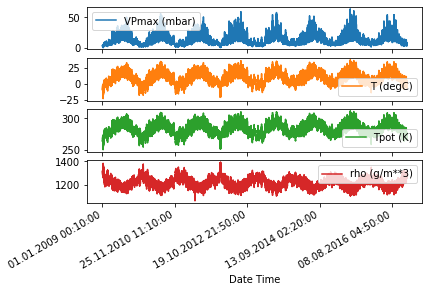

In [5]:
features[features.columns[:4]].plot(subplots=True)

In [6]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

In [7]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset_standardized = (dataset-data_mean)/data_std

In [8]:
features=dataset=None

In [9]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In this tutorial, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days. For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(i.e. 12*6) observations is used.

In [10]:
past_history = 720
future_target = 1 #72
STEP = 6

x_train_multi, y_train_multi = multivariate_data(dataset_standardized, dataset_standardized[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP) #aquí el param. single_step=False
x_val_multi, y_val_multi = multivariate_data(dataset_standardized, dataset_standardized[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP) #aquí el param. single_step=False

In [11]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 4)

 Target temperature to predict : (1,)


In [12]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [13]:
y_train_multi=x_val_multi=y_val_multi=dataset_standardized=None

### Comprobamos lo que hace 'shuffle(BUFFER_SIZE) y batch(BATCH_SIZE)'

In [14]:
for x, y in train_data_multi.take(2):
    print(x[0][-1])
    print(y[0])

tf.Tensor([-0.52347294 -0.36278311 -0.15054648 -0.34906747], shape=(4,), dtype=float64)
tf.Tensor([-0.39288713], shape=(1,), dtype=float64)
tf.Tensor([-0.70966822 -0.63371929 -0.6455583   0.62968324], shape=(4,), dtype=float64)
tf.Tensor([-0.6684547], shape=(1,), dtype=float64)


### Seguimos con el modelado

In [15]:
def create_time_steps(length):
  return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [16]:
temps_mean = data_mean[1]
temps_std = data_std[1]

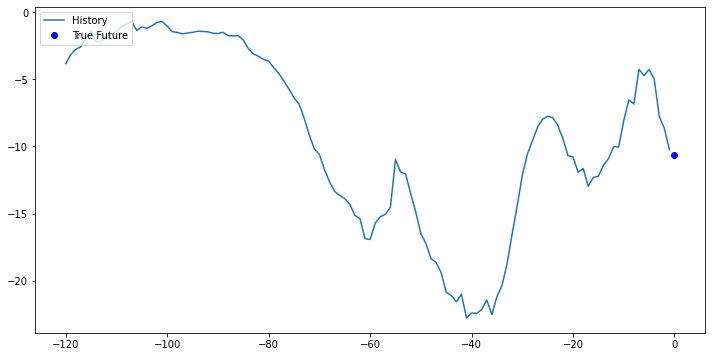

In [17]:
for x, y in train_data_multi.take(1):
  x_denormalized = (x[0])*temps_std+temps_mean
  y_denormalized = (y[0])*temps_std+temps_mean

  multi_step_plot(x_denormalized, y_denormalized, np.array([0]))


In [18]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,  # "Boolean. Whether to return the last output. in the output sequence, or the full sequence"
                                          input_shape=x_train_multi.shape[-2:]))
single_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
single_step_model.add(tf.keras.layers.Dense(future_target))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')


In [19]:
EVALUATION_INTERVAL = 100
EPOCHS = 3

single_step_history = single_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/3
100/100 [==============================] - 23s 207ms/step - loss: 1110.1538 - val_loss: 0.2128
Epoch 2/3
100/100 [==============================] - 19s 190ms/step - loss: 0.2259 - val_loss: 0.1225
Epoch 3/3
100/100 [==============================] - 19s 191ms/step - loss: 0.1326 - val_loss: 0.0925


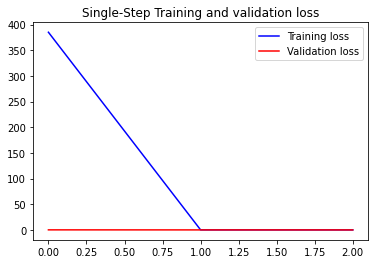

In [20]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()
  
plot_train_history(single_step_history, 'Single-Step Training and validation loss')

### Ahora ya calculamos el mae de 300 registros de prueba:

In [21]:
mae_list = []
for x, y in val_data_multi.take(300):
    mae_list.append(tf.keras.metrics.mae(y[0].numpy(), single_step_model.predict(x)[0]).numpy())
    
print('total mae: {}'.format(np.mean(mae_list)))

total mae: 0.10154896974563599


### Y ahora el 'mae' de los datos devueltos a su escala original de temperaturas

In [ ]:
mae_scaled_list = []
for x, y in val_data_multi.take(100):
    x_denormalized = (x[0]*temps_std)+temps_mean
    y_denormalized = (y[0]*temps_std)+temps_mean
    mae_scaled_list.append(tf.keras.metrics.mae(y_denormalized[0], (single_step_model.predict(x)[0]*temps_std)+temps_mean))
    
print('total mae_scaled: {}'.format(np.mean(mae_scaled_list)))

total mae_scaled: 0.8077419996261597


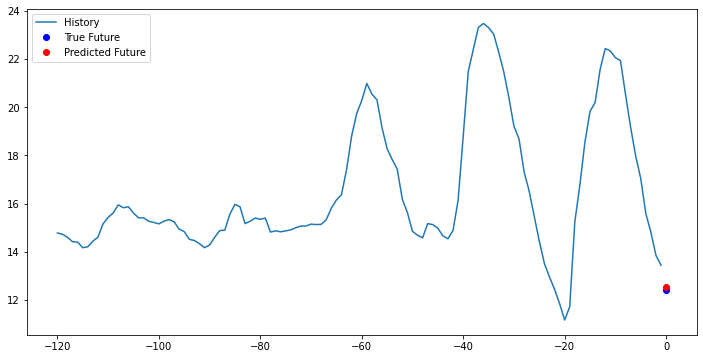

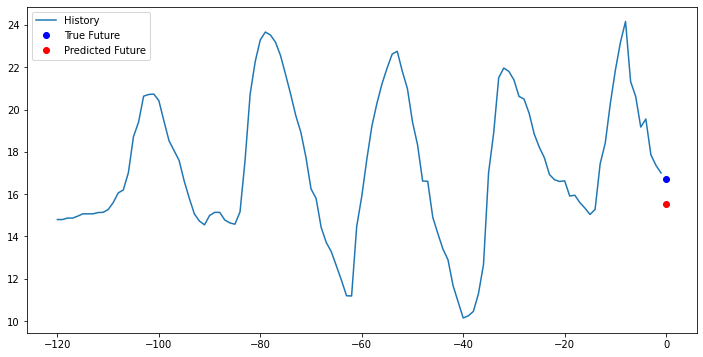

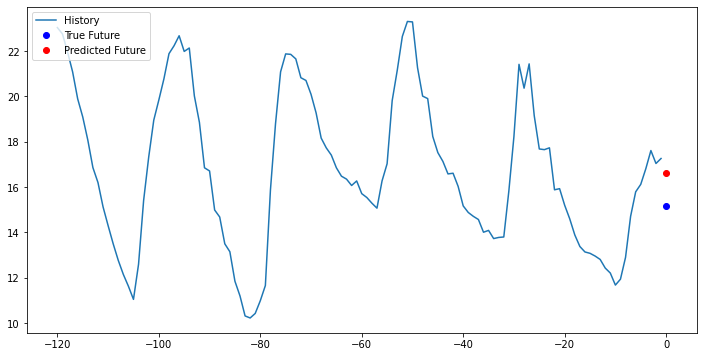

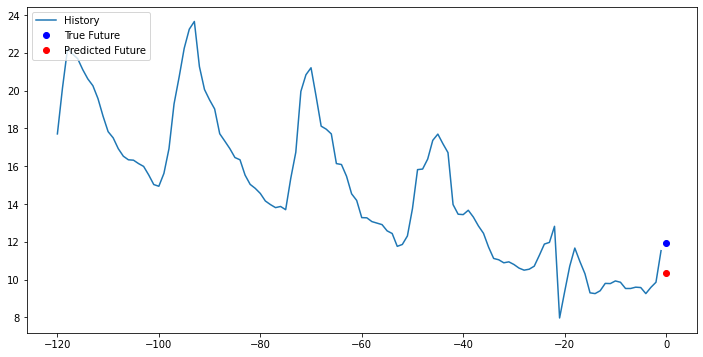

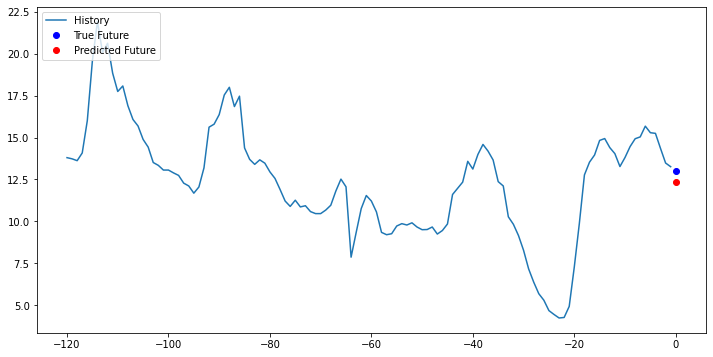

In [22]:
for x, y in val_data_multi.take(5):
    x_denormalized = (x[0])*temps_std+temps_mean
    y_denormalized = (y[0])*temps_std+temps_mean
    
    multi_step_plot(x_denormalized, y_denormalized, (single_step_model.predict(x)[0]*temps_std)+temps_mean)

In [23]:
single_step_model=single_step_history=mae_scaled_list=None

### Y con bayesian tuning:

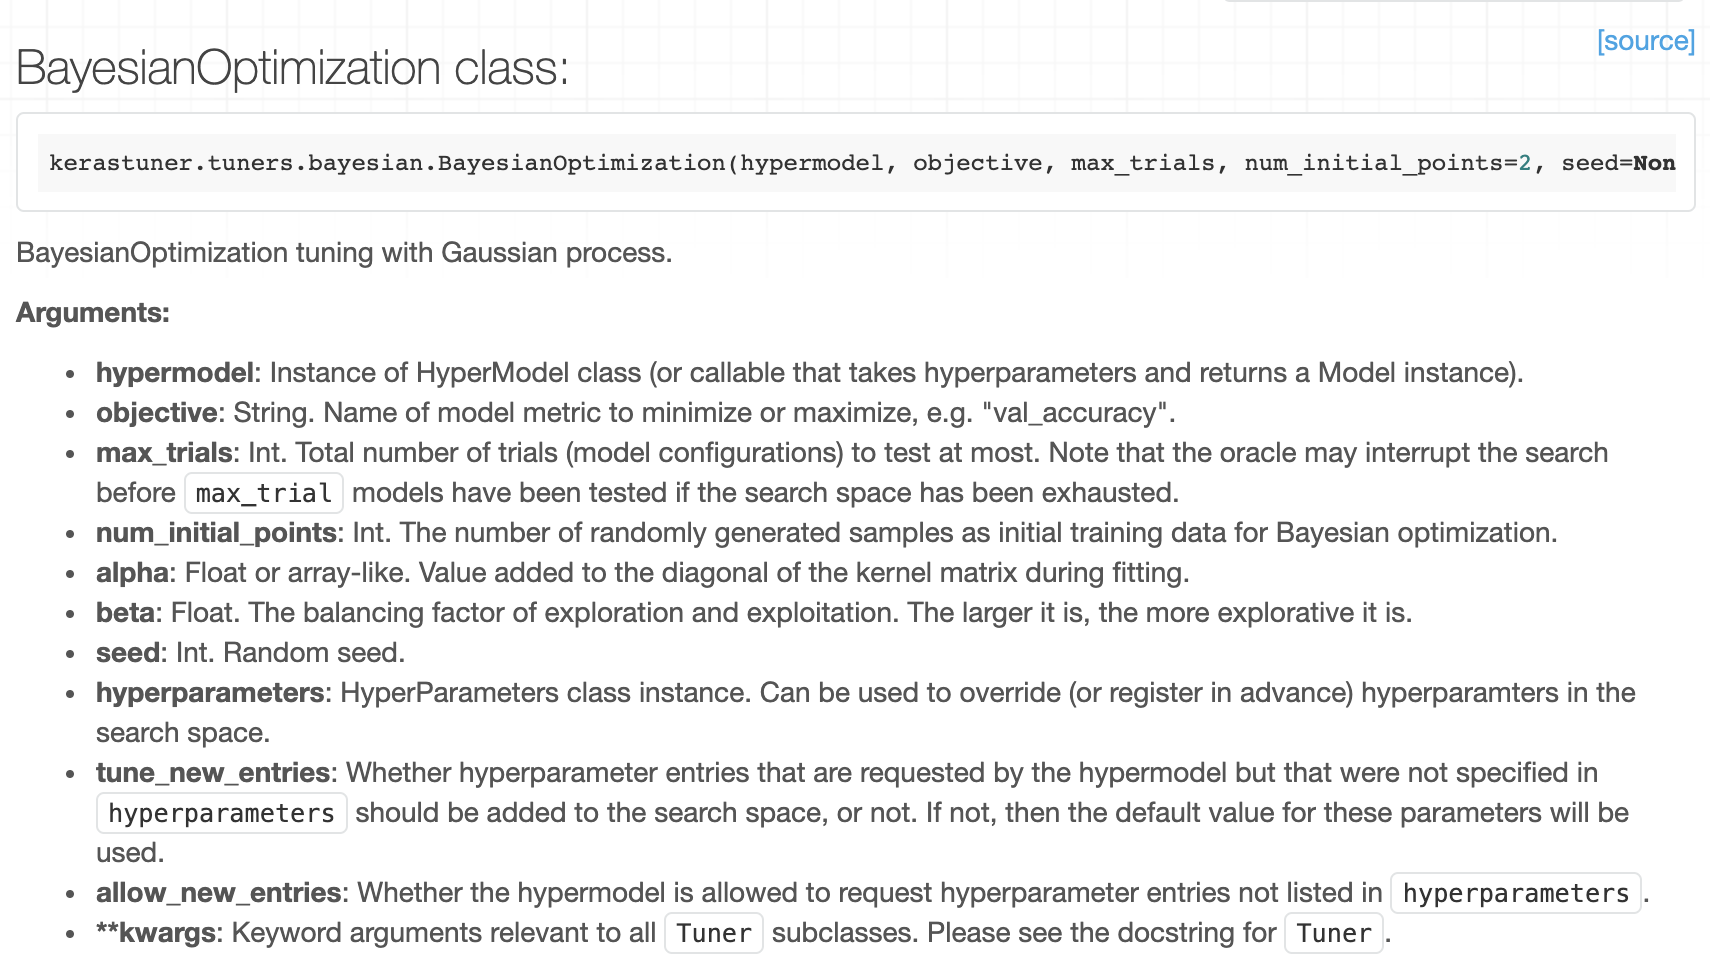

In [25]:
!pip install keras-tuner
import os
from tensorflow import keras
from kerastuner import BayesianOptimization

def build_model_2(hp):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=hp.Int('units',min_value=16,
                                        max_value=32,
                                        step=16), 
                                        #activation='relu', 
                                        return_sequences=True, #ESTO NO LO APLICO ENTRE LA SIGUIENTE Y LA CAPA DE SALIDA, CHECK
                                        input_shape=x_train_multi.shape[-2:]))
    model.add(keras.layers.LSTM(units=hp.Int('units',min_value=16,
                                        max_value=32,
                                        step=16),  
                                        activation='relu'))
    model.add(keras.layers.Dense(future_target))

    model.compile(loss='mae', optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),
                   metrics=['mae'])
    return model

# define model
bayesian_opt_tuner_2 = BayesianOptimization(
    build_model_2,
    objective='mae',
    max_trials=3,
    executions_per_trial=1,
    directory=os.path.normpath('C:/keras_tuning'),
    project_name='timeseries_temp_ts_test_from_TF_ex_multivar_multistep_2',
    overwrite=True)

EVALUATION_INTERVAL = 200
EPOCHS = 3
bayesian_opt_tuner_2.search(train_data_multi, 
             epochs=EPOCHS,
             validation_data=val_data_multi,
             validation_steps=50,  
             steps_per_epoch=EVALUATION_INTERVAL)

Trial 3 Complete [00h 02m 10s]
mae: 0.09884603321552277

Best mae So Far: 0.09027943015098572
Total elapsed time: 00h 05m 47s
INFO:tensorflow:Oracle triggered exit


Estos son los valores de los epochs iniciales de un nuevo modelo de estas características:

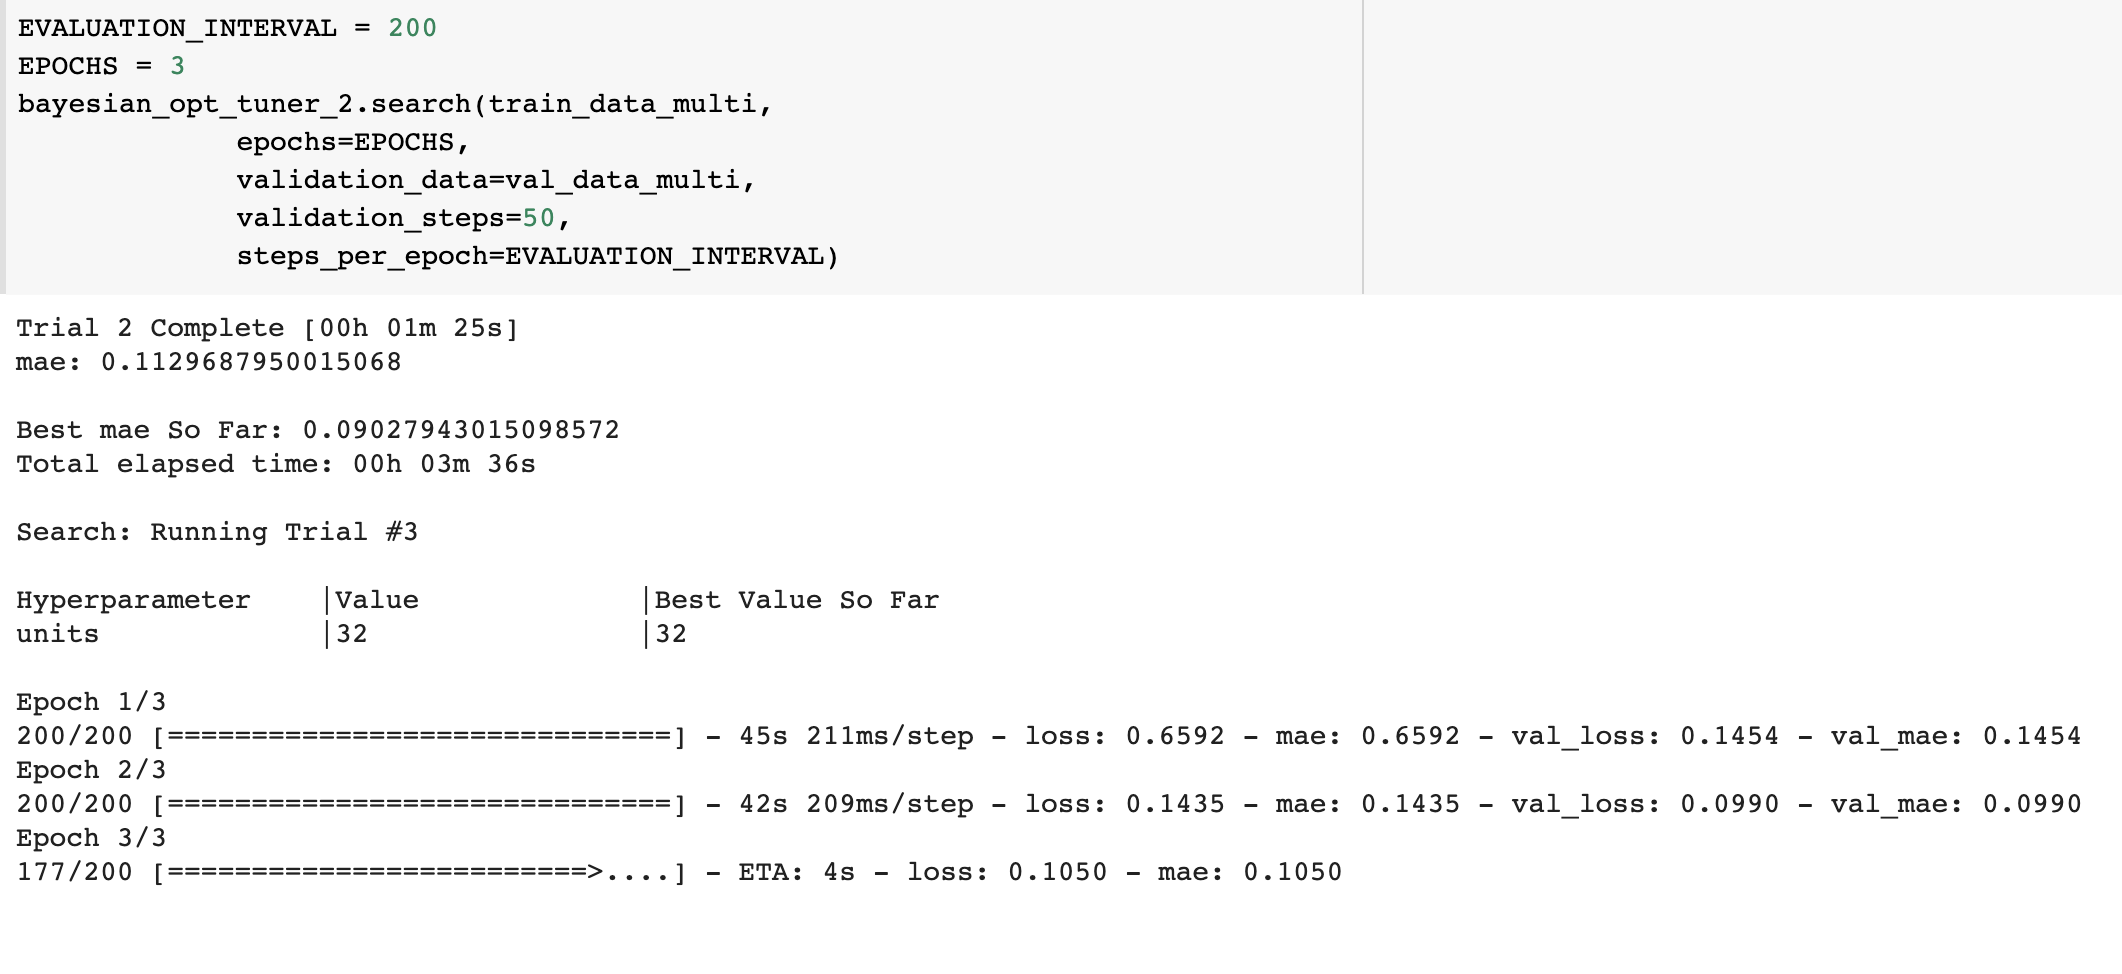

In [ ]:
best_MULTIVAR_MULTISTEP_LSTM_model = bayesian_opt_tuner_2.get_best_models(num_models=1)[0]
best_MULTIVAR_MULTISTEP_LSTM_model.get_config()

lo guardamos con su estado:

In [27]:
# serialize model to JSON
'''
best_MULTIVAR_MULTISTEP_LSTM_model_json = best_MULTIVAR_MULTISTEP_LSTM_model.to_json()
with open("/best_MULTIVAR_MULTISTEP_LSTM_model_v2.json", "w") as json_file:
    json_file.write(best_MULTIVAR_MULTISTEP_LSTM_model_json)
# serialize weights to HDF5
best_MULTIVAR_MULTISTEP_LSTM_model.save_weights("/best_MULTIVAR_MULTISTEP_LSTM_model_v2.h5")
print("Saved model to disk")'''

#source: https://keras.io/getting_started/faq/#how-can-i-save-a-keras-model

best_MULTIVAR_MULTISTEP_LSTM_model.save('best_MULTIVAR_MULTISTEP_LSTM_model_pretrained')  # creates a HDF5 file 'my_model.h5'
del best_MULTIVAR_MULTISTEP_LSTM_model  # deletes the existing model

INFO:tensorflow:Assets written to: best_MULTIVAR_MULTISTEP_LSTM_model_pretrained/assets


INFO:tensorflow:Assets written to: best_MULTIVAR_MULTISTEP_LSTM_model_pretrained/assets


lo cargamos

In [28]:
'''from tensorflow.keras.models import model_from_json
# load json and create model
json_file = open('/best_MULTIVAR_MULTISTEP_LSTM_model_v2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/best_MULTIVAR_MULTISTEP_LSTM_model_v2.h5")
print("Loaded model from disk")'''

from tensorflow.keras.models import load_model

loaded_MULTIVAR_MULTISTEP_LSTM_model = load_model('best_MULTIVAR_MULTISTEP_LSTM_model_pretrained')

In [ ]:
loaded_MULTIVAR_MULTISTEP_LSTM_model.get_config()


In [29]:
model = loaded_MULTIVAR_MULTISTEP_LSTM_model
model.fit(train_data_multi, 
             epochs=6,
             validation_data=val_data_multi,
             validation_steps=50,  
             steps_per_epoch=EVALUATION_INTERVAL, initial_epoch=3)


Epoch 4/6
200/200 [==============================] - 46s 215ms/step - loss: 0.0794 - mean_absolute_error: 0.0794 - val_loss: 0.0590 - val_mean_absolute_error: 0.0590
Epoch 5/6
200/200 [==============================] - 42s 212ms/step - loss: 0.0722 - mean_absolute_error: 0.0722 - val_loss: 0.0591 - val_mean_absolute_error: 0.0591
Epoch 6/6
200/200 [==============================] - 44s 220ms/step - loss: 0.0699 - mean_absolute_error: 0.0699 - val_loss: 0.0622 - val_mean_absolute_error: 0.0622


Tras re-entrenar con el modelo cargado pre-entrenado

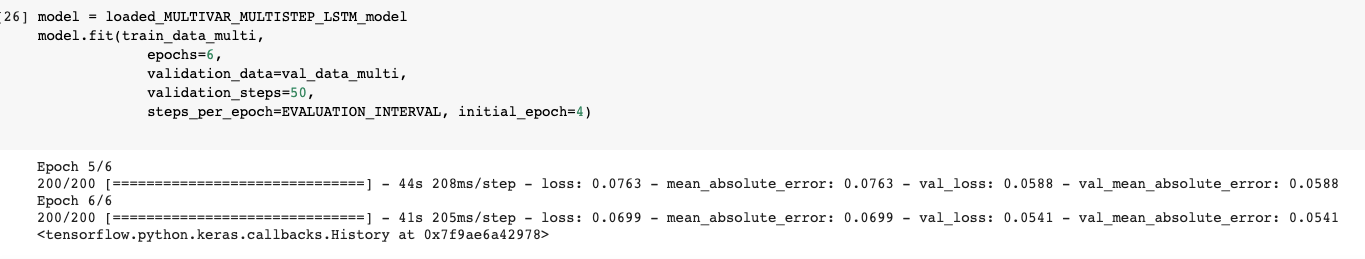

# Saves the model to continue training the loaded model

In [ ]:
model.save('best_MULTIVAR_MULTISTEP_LSTM_model_pretrained')  # creates a HDF5 file 'my_model.h5'
del model

INFO:tensorflow:Assets written to: best_MULTIVAR_MULTISTEP_LSTM_model_pretrained/assets


INFO:tensorflow:Assets written to: best_MULTIVAR_MULTISTEP_LSTM_model_pretrained/assets


In [ ]:
model = load_model('best_MULTIVAR_MULTISTEP_LSTM_model_pretrained')

model.fit(train_data_multi, 
             epochs=10,
             validation_data=val_data_multi,
             validation_steps=50,  
             steps_per_epoch=EVALUATION_INTERVAL, initial_epoch=6)


Epoch 7/10
200/200 [==============================] - 43s 204ms/step - loss: 0.0707 - mean_absolute_error: 0.0707 - val_loss: 0.0562 - val_mean_absolute_error: 0.0562
Epoch 8/10
200/200 [==============================] - 41s 203ms/step - loss: 0.0665 - mean_absolute_error: 0.0665 - val_loss: 0.0562 - val_mean_absolute_error: 0.0562
Epoch 9/10
200/200 [==============================] - 43s 216ms/step - loss: 0.0656 - mean_absolute_error: 0.0656 - val_loss: 0.0542 - val_mean_absolute_error: 0.0542
Epoch 10/10
200/200 [==============================] - 43s 214ms/step - loss: 0.0624 - mean_absolute_error: 0.0624 - val_loss: 0.0595 - val_mean_absolute_error: 0.0595


## 
* Queda pendiente ver por qué aquí evalúa cada 1 training sample
* PLOTEAR TRAIN-VALIDATOIN LOSSES DEL BEST MODEL
* PROBAR BASELINE MODEL!!!

In [ ]:
#best_MULTIVAR_MULTISTEP_LSTM_model = bayesian_opt_tuner_2.get_best_models(num_models=1)[0]


In [31]:
mae_list = []
for x, y in val_data_multi.take(300):
    mae_list.append(tf.keras.metrics.mae(y[0].numpy(), model.predict(x)[0]).numpy())
    
print('total mae: {}'.format(np.mean(mae_list)))

total mae: 0.07272622734308243


### Y en su escala original

In [32]:
mae_scaled_list = []
for x, y in val_data_multi.take(100):
    x_denormalized = (x[0]*temps_std)+temps_mean
    y_denormalized = (y[0]*temps_std)+temps_mean
    mae_scaled_list.append(tf.keras.metrics.mae(y_denormalized[0], (model.predict(x)[0]*temps_std)+temps_mean))
    
print('total mae_scaled: {}'.format(np.mean(mae_scaled_list)))

total mae_scaled: 0.5420066714286804


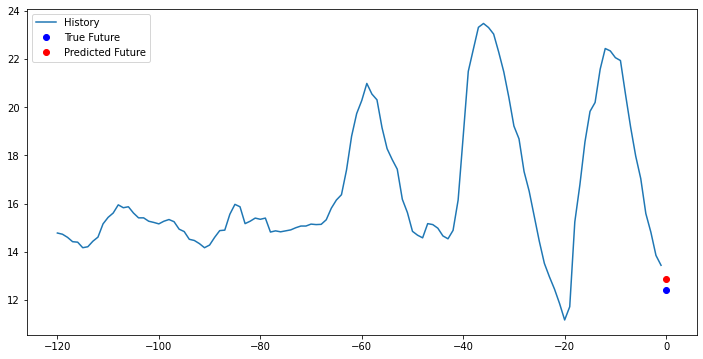

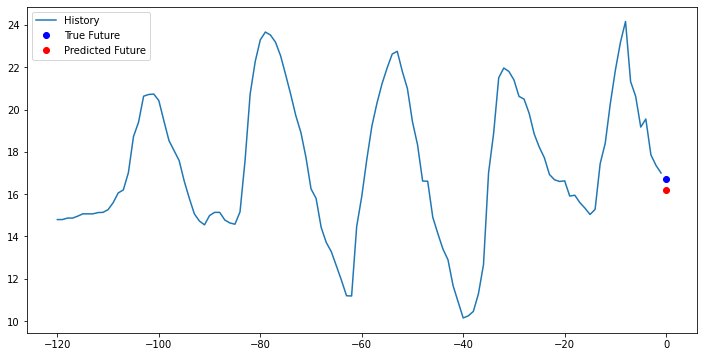

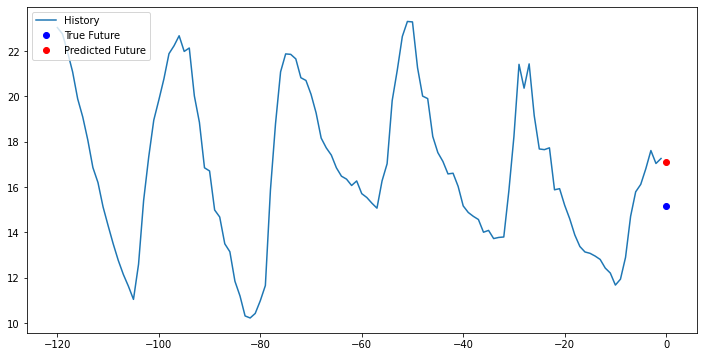

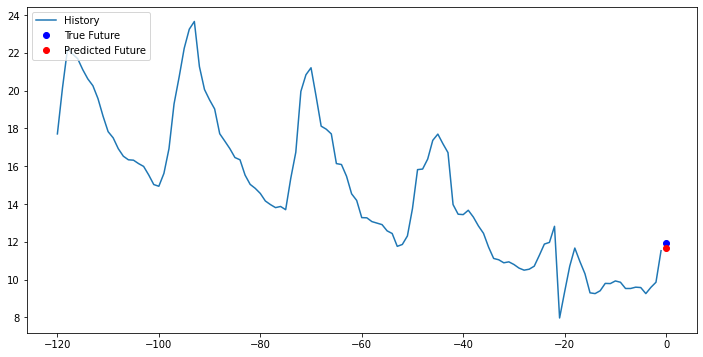

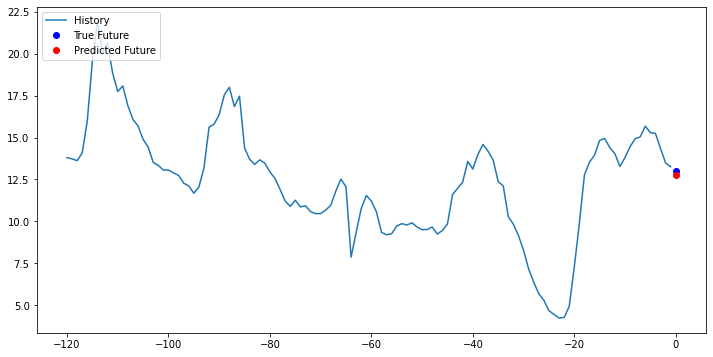

In [33]:
for x, y in val_data_multi.take(5):
    x_denormalized = (x[0])*temps_std+temps_mean
    y_denormalized = (y[0])*temps_std+temps_mean
    
    multi_step_plot(x_denormalized, y_denormalized, (model.predict(x)[0]*temps_std)+temps_mean)